#  Proyecto Amparo con LangChain y LangGraph
Este proyecto se desarrollará utilizando una **Arquitectura de agente** tipo **Superviro**.
En esta arquitectura usa un LLM para orquestar y delegar a agentes individuales

### Objetivos:
* Crear un grafo con una arquitectura multiagente tipo Supervisor
* Crear un agente supervisor que delegará los trabajos al resto de agentes
* Crear otros 5 agentes especializados en trabajos y tareas
    * Agente **Amparo** --> Agente principal
    * Agente **Buker** --> Agente especializado en BUK
    * Agente **Planner** --> Agente especializado en entrega de tareas
    * Agente **Reglamento** --> Agente especializado en consultas del reglamento interno
    * Agente **Search Web** --> Agente especializado en consultas web para temas más generales
### Alcance:

El desarrollo de este sistema multiagente se desarrollará en N fases.
En una 1era fase se espera tener creado los nodos (sin ejecuión) y el grafo para la visualización de la arquitectura.


### Codigo del proyecto

### Instalación de paquetes y librerias
* lanchain_openai
* langchain_core
* langgraph
* langchain_community

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_community langchain_anthropic langchain_experimental

### Importación de librerias


In [52]:
from typing import TypedDict, Literal
from langgraph.graph import MessagesState, END, START, StateGraph
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI
from dotenv import find_dotenv, load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import Image, display
from typing import TypedDict, Optional, Dict, List
from pydantic import BaseModel
from typing import Literal
from typing import Annotated

### Carga de variables de entorno
* Agrega las API Keys 

In [3]:
# Cargar variables de entorno
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

True

### Definimos una estructura para el estado


In [5]:
class State(TypedDict):
    graph_state: str
    messages: list

#### Nueva estructura del estado.
Esta nueva estructura utiliza 3 niveles distintos de estados

**InputState - SupervisorState - PrivateState**

In [90]:
# Estado de Entrada: Contiene la consulta que hará el usuario
class InputState(TypedDict):
    user_query: str
    context: Optional[Dict]

class SupervisorState(TypedDict):
    user_query: str
    assigned_agent: Optional[str]  # Nombre del agente que procesará la tarea
    agent_responses: Annotated[List[str], "accumulate"]  # ✅ Cambiado de "agent_response" a "agent_responses"
    conversation_history: List[str]  # Historial del usuario
    task_status: Dict[str, str]  # Estado de cada tarea asignada
    
# Estado privado para cada agente:
class BukerState(TypedDict):
    buk_data: Optional[str] # Información que se obtiene desde Buk

class PlannerState(TypedDict):
    task_list: List[str] # Lista de tareas asignadas a la persona
    
class ReglamentoState(TypedDict):
    regulation_response: Optional[str] # Respuesta a la consulta del reglamento

class SearchState(TypedDict):
    search_results: Optional[str] # Resultados de busqueda web
    

### Definimos los agentes o miembros:
Estos son los que estarán en este sistema multi-agente tipo supervisor
   * Agente **Amparo** --> Agente principal
   * Agente **Buker** --> Agente especializado en BUK
   * Agente **Planner** --> Agente especializado en entrega de tareas
   * Agente **Reglamento** --> Agente especializado en consultas del reglamento interno
   * Agente **Search Web** --> Agente especializado en consultas web para temas más generales

In [5]:
members = ["amparo", "buker", "planner", "reglamento", "search_web"]
options = members + ["FINISH"]

### System Prompt
Entregamos el prompt que usará el supervisor para dirigir el trabajo a los diferentes agente

In [6]:
# Prompt del sistema
system_prompt = (
    "Eres un supervisor de RRHH que trabaja para las empresas constructora del mar II e inmobiliaria costanera pacifico "
    f"y eres el encargado de gestionar las conversaciones y solicitudes entre los siguientes miembros: {members}. "
    "Ante la siguiente solicitud del usuario, responda con el miembro que debe actuar a continuación. "
    "Cada miembro realizará una tarea y responderá con sus resultados y el estado. Al finalizar, responda con FINISH."
)

### Creación del Router
Este se encargará de dirigir la flujo entre los agentes

In [12]:
class Router(TypedDict):
    next: Literal[options]

### Nuevo Router:

In [91]:
class Router(BaseModel):
    next: Literal["buker", "planner", "reglamento", "search_web", "FINISH"]


### Selección del modelo
En este caso se usará **gpt-3.5-turbo**

In [8]:
# Configurar modelo de lenguaje
llm = ChatOpenAI(model="gpt-4o")

### Creamos el Agente Supervisor
 Este se encargará de orquestar el sistema

In [86]:
# Definir nodo supervisor
def amparo_node(state: SupervisorState) -> Command:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    if goto == "FINISH":
        goto = END  # ✅ Usa END en vez de un string "END"
    
    return Command(goto=goto, update={"next": goto})

### Creación nueva versión Agente Supervisor

In [92]:
def amparo_node(state: SupervisorState) -> Command:
    # 🔹 Convertir historial de conversación en mensajes estructurados
    history = [{"role": "user", "content": msg} for msg in state.get("conversation_history", [])]

    # 🔹 Construir el mensaje con el sistema y el historial
    messages = [{"role": "system", "content": system_prompt}] + history

    # 🔹 Agregar la consulta del usuario al final del historial
    if "user_query" in state:
        messages.append({"role": "user", "content": state["user_query"]})  # ✅ Se agrega user_query

    print("\n📌 Verificando estructura de messages:", messages)  # 🚀 Debug

    # 🔹 Invocar el modelo con la estructura corregida
    response = llm.with_structured_output(Router).invoke(messages)

    # 🔹 Obtener el siguiente nodo
    goto = response.next  

    if goto == "FINISH":
        goto = END  

    updated_state = {
        "next": goto,
        "task_status": {**state.get("task_status", {}), "supervisor": f"Delegando a {goto}"},
        "conversation_history": state.get("conversation_history", []) + [f"Supervisor asignó tarea a {goto}"]
    }

    return Command(goto=goto, update=updated_state)


### Continuamos con la creación preliminar del resto de agentes


In [88]:
# Definir los nodos restantes como Commands en vez de strings
# def amparo(state: State) -> Command:
  #  return Command(goto="supervisor_node")

def buker(state: State) -> Command:
    return Command(goto="supervisor_node")

def planner(state: State) -> Command:
    return Command(goto="supervisor_node")

def reglamento(state: State) -> Command:
    return Command(goto="supervisor_node")

### Nueva Versión del Agente Buker
En esta nueva versión se utilizará el SupervisorState y el BukerState --> Privado para el agente Buker


In [93]:
def buker(state: SupervisorState) -> Command:
    user_query = state["user_query"]

    # 🔹 Simulación de consulta a BUK
    buk_data = f"Información desde BUK para: {user_query}"

    # 🔹 Creación del estado privado para Buker
    buker_state: BukerState = {"buk_data": buk_data}

    # 🔹 Actualización del estado general y decisión del siguiente nodo
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [buk_data],  # ✅ Ahora es una lista
        "task_status": {**state.get("task_status", {}), "buker": "completado"},
    }

    return Command(update=updated_state, goto="amparo_node")



### Nueva Versión del Agente Planner
En esta nueva versión se utilizará el SupervisorState y el PlannerState --> Privado para el agente Planner

In [94]:
def planner(state: SupervisorState) -> Command:
    user_query = state["user_query"]

    # 🔹 Simulación de una consulta a la planificación
    planner_data = f"Información de la planificación para: {user_query}"

    # 🔹 Creación del estado privado para Planner
    planner_state: PlannerState = {"task_list": [planner_data]}

    # 🔹 Actualización del estado general y decisión del siguiente nodo
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [planner_data],  # ✅ Se agrega a la lista
        "task_status": {**state.get("task_status", {}), "planner": "completado"},
    }

    return Command(update=updated_state, goto="amparo_node")




### Nueva Versión del Agente Reglamento
En esta nueva versión se utilizará el SupervisorState y el ReglamentoState --> Privado para el agente Reglamento

In [95]:
def reglamento(state: SupervisorState) -> Command:
    user_query = state["user_query"]

    # 🔹 Simulación de consulta al reglamento interno
    reglamento_data = f"Información del reglamento para: {user_query}"

    # 🔹 Creación del estado privado para ReglamentoState
    reglamento_state: ReglamentoState = {"regulation_response": reglamento_data}

    # 🔹 Actualización del estado general y decisión del siguiente nodo
    updated_state = {
        "agent_responses": state.get("agent_responses", []) + [reglamento_data],  # ✅ Se agrega como un elemento a la lista
        "task_status": {**state.get("task_status", {}), "reglamento": "completado"},
    }

    return Command(update=updated_state, goto="amparo_node")



### Tools y agent Search Web

In [96]:
# Configurar herramientas de búsqueda
tavily_tool = TavilySearchResults(max_results=5)

In [97]:
# Crear agente de investigación
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="Eres un agente especializado en busqueda web"
)

# Nodo de búsqueda web
def research_node(state: SupervisorState) -> Command:
    result = research_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="researcher")]},
        goto="supervisor_node",
    )

def search_web(state: SupervisorState) -> Command:
    return Command(goto="amparo_node")

### Construcción del Grafo

In [98]:
builder = StateGraph(SupervisorState, input=InputState)

### Añadir Nodos

In [99]:
builder.add_node("amparo", amparo_node)
builder.add_node("buker", buker)
builder.add_node("planner", planner)
builder.add_node("reglamento", reglamento)
builder.add_node("search_web", search_web)

### Definiciónde Edges

In [100]:
# Definir conexiones entre nodos
builder.add_edge(START, "amparo")
builder.add_edge("amparo", "buker")
builder.add_edge("buker", "amparo")
builder.add_edge("amparo", "planner")
builder.add_edge("planner", "amparo")
builder.add_edge("amparo", "reglamento")
builder.add_edge("reglamento", "amparo")
builder.add_edge("amparo", "search_web")
builder.add_edge("search_web", "amparo")
builder.add_edge("amparo", END)  # ✅ Asegurar que END es un valor válido

### Compilación y visaulización del grafo

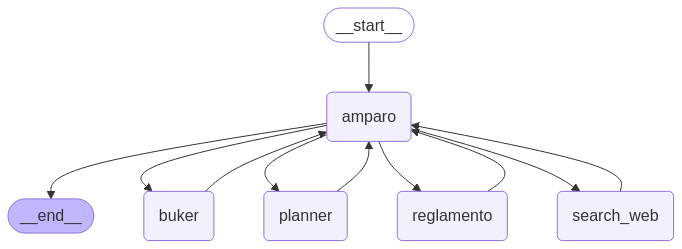

In [101]:
# Compilar y mostrar el gráfico de estados
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [102]:

response = graph.invoke({"user_query": "Quien es el presidente de los Estados Unidos de América"})
print(response)


📌 Verificando estructura de messages: [{'role': 'system', 'content': "Eres un supervisor de RRHH que trabaja para las empresas constructora del mar II e inmobiliaria costanera pacifico y eres el encargado de gestionar las conversaciones y solicitudes entre los siguientes miembros: ['amparo', 'buker', 'planner', 'reglamento', 'search_web']. Ante la siguiente solicitud del usuario, responda con el miembro que debe actuar a continuación. Cada miembro realizará una tarea y responderá con sus resultados y el estado. Al finalizar, responda con FINISH."}, {'role': 'user', 'content': 'Quien es el presidente de los Estados Unidos de América'}]


InvalidUpdateError: At key 'agent_responses': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE